<a href="https://colab.research.google.com/github/gyuwonh-ai/SeSAC_miniProject_1Team/blob/main/mermaid/mermaid_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mermaid 자세 기준을 위한 EDA

<가설>

- 어깨를 들지 않는 것이 중요하니 귀 어깨 사이의 거리 측정해보자.
- 허리가 얼마나 구부러지는지도 중요할것이다.

In [ ]:
# 1. 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import glob
import os
from google.colab import drive

# 1. 드라이브 마운트
try:
    drive.mount('/content/drive')
except:
    pass

# --- 2. Mermaid 전용 지표 계산 함수 ---
def calculate_mermaid_metrics_per_frame(df):
    df_out = df.copy()

    # [삭제됨] torso_len 계산 로직
    # 이유: 이미 정규화된 데이터이므로, 몸통 길이는 항상 1.0입니다.
    # 따라서 나누기 연산(/ torso_len)을 할 필요가 없습니다.

    # --- [Metric 1] 귀-어깨 거리 (Ear-Shoulder Distance) ---
    # 이미 정규화된 좌표이므로, 유클리드 거리 공식만 쓰면 그게 바로 '비율'입니다.

    # 왼쪽 귀-어깨 거리
    df_out['L_Ear_Shoulder_Dist'] = np.sqrt(
        (df['norm_Left_Ear_x'] - df['norm_Left_Shoulder_x'])**2 +
        (df['norm_Left_Ear_y'] - df['norm_Left_Shoulder_y'])**2
    )

    # 오른쪽 귀-어깨 거리
    df_out['R_Ear_Shoulder_Dist'] = np.sqrt(
        (df['norm_Right_Ear_x'] - df['norm_Right_Shoulder_x'])**2 +
        (df['norm_Right_Ear_y'] - df['norm_Right_Shoulder_y'])**2
    )

    # --- [Metric 2] 척추 측면 굴곡 (Spine Lateral Flexion) ---
    # 중점 계산
    mid_sh_x = (df['norm_Left_Shoulder_x'] + df['norm_Right_Shoulder_x']) / 2
    mid_sh_y = (df['norm_Left_Shoulder_y'] + df['norm_Right_Shoulder_y']) / 2
    mid_hip_x = (df['norm_Left_Hip_x'] + df['norm_Right_Hip_x']) / 2
    mid_hip_y = (df['norm_Left_Hip_y'] + df['norm_Right_Hip_y']) / 2

    spine_dx = mid_sh_x - mid_hip_x
    spine_dy = mid_sh_y - mid_hip_y

    # 각도 계산 (수직선 기준)
    df_out['Spine_Flexion_Angle'] = np.degrees(np.arctan2(spine_dx, -spine_dy))

    # --- [Metric 3] 골반 기울기 (Pelvis Tilt) ---
    # 좌우 골반 높이 차이 (이미 정규화됨)
    df_out['Pelvis_Tilt_Diff'] = df['norm_Left_Hip_y'] - df['norm_Right_Hip_y']

    return df_out

# --- 3. 메인 실행부 ---

# [경로 설정]
drive_root = '/content/drive/MyDrive/shared_googledrive(Sessac Final Project)/dataset/Mermaid'
norm_folder_path = os.path.join(drive_root, 'norm_11x') # Mermaid 폴더 확인!
all_files = glob.glob(os.path.join(norm_folder_path, "norm_*.csv"))

output_path = '/content/drive/MyDrive/shared_googledrive(Sessac Final Project)/analysis'

if not all_files:
    print(f"❌ '{norm_folder_path}' 경로에 파일이 없습니다.")
else:
    print(f"✅ 총 {len(all_files)}개의 Mermaid 파일을 프레임 단위로 분석합니다.")

    all_frames_list = []

    for i, file_path in enumerate(all_files):
        filename = os.path.basename(file_path)

        try:
            # 1. 파일명 메타데이터 추출
            clean_name = filename.replace('norm_', '').replace('.csv', '')
            parts = clean_name.split('_')

            # (파일명 규칙에 맞춰 수정 필요)
            # 예: norm_필라테스_가산_A_Mermaid_고급_actorP01_...
            place = parts[2]
            level = parts[5]
            person_id = parts[6]
            pose_name = parts[4]

            for part in parts:
                if part.startswith('actor'): person_id = part
                if part in ['고급', '중급', '초급']: level = part
                if 'mermaid' in part.lower(): pose_name = 'Mermaid'

            if pose_name != 'Mermaid': continue

            # 2. 데이터 읽기 & 보간 (Interpolation)
            df = pd.read_csv(file_path)

            # (보간 로직은 동일하게 적용)
            norm_cols = [c for c in df.columns if c.startswith('norm_')]
            df[norm_cols] = df[norm_cols].interpolate(method='linear', limit=5)

            # 3. 프레임별 지표 계산
            df_analyzed = calculate_mermaid_metrics_per_frame(df)

            # 4. 메타데이터 추가 (모든 행에 복사됨)
            df_analyzed['Source_File'] = filename
            df_analyzed['Person_ID'] = person_id
            df_analyzed['Level'] = level

            # 필요한 컬럼만 선택해서 저장 (용량 절약)
            cols_to_keep = ['Frame', 'Person_ID', 'Level', 'Source_File',
                            'L_Ear_Shoulder_Dist', 'R_Ear_Shoulder_Dist',
                            'Spine_Flexion_Angle', 'Pelvis_Tilt_Diff']

            all_frames_list.append(df_analyzed[cols_to_keep])

        except Exception as e:
            print(f"⚠️ {filename} 오류: {e}")

    # 저장
    if all_frames_list:
        df_final = pd.concat(all_frames_list, ignore_index=True)

        output_dir = os.path.join(output_path, "keypoint_Mermaid_Analysis")
        save_path = os.path.join(output_dir, "EDA_Mermaid_Frame_by_Frame_2.csv")

        os.makedirs(output_dir, exist_ok=True)
        df_final.to_csv(save_path, index=False)

        print(f"✅ 저장 완료! {save_path}")
        print(f"총 프레임 수: {len(df_final)}")
        print(df_final.head())
    else:
        print("데이터 없음")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 총 257개의 Mermaid 파일을 프레임 단위로 분석합니다.
✅ 저장 완료! /content/drive/MyDrive/shared_googledrive(Sessac Final Project)/analysis/keypoint_Mermaid_Analysis/EDA_Mermaid_Frame_by_Frame_2.csv
총 프레임 수: 212359
   Frame  Person_ID  Level                                        Source_File  \
0      0  actorP061  고급  norm_필라테스_가산_A__Mermaid_고급_actorP06...   
1      1  actorP061  고급  norm_필라테스_가산_A__Mermaid_고급_actorP06...   
2      2  actorP061  고급  norm_필라테스_가산_A__Mermaid_고급_actorP06...   
3      3  actorP061  고급  norm_필라테스_가산_A__Mermaid_고급_actorP06...   
4      4  actorP061  고급  norm_필라테스_가산_A__Mermaid_고급_actorP06...   

   L_Ear_Shoulder_Dist  R_Ear_Shoulder_Dist  Spine_Flexion_Angle  \
0             0.529378             0.526950            -0.987063   
1             0.534026             0.525692           

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/shared_googledrive(Sessac Final Project)/analysis/keypoint_Mermaid_Analysis/EDA_Mermaid_Frame_by_Frame_2.csv')
df

,Frame,Person_ID,Level,Source_File,L_Ear_Shoulder_Dist,R_Ear_Shoulder_Dist,Spine_Flexion_Angle,Pelvis_Tilt_Diff
0,0,actorP061,고급,norm_필라테스_가산_A__Mermaid_고급_actorP06...,0.529378,0.526950,-0.987063,-0.015961
1,1,actorP061,고급,norm_필라테스_가산_A__Mermaid_고급_actorP06...,0.534026,0.525692,-0.726292,-0.013183
2,2,actorP061,고급,norm_필라테스_가산_A__Mermaid_고급_actorP06...,0.536147,0.524883,-0.947534,-0.012071
3,3,actorP061,고급,norm_필라테스_가산_A__Mermaid_고급_actorP06...,0.533565,0.524489,-0.958709,-0.013357
4,4,actorP061,고급,norm_필라테스_가산_A__Mermaid_고급_actorP06...,0.535563,0.524701,-0.973796,-0.011378
...,...,...,...,...,...,...,...,...
212354,937,actorP090,고급,norm_필라테스_가산_B_Mat_Mermaid_고급_actor...,0.572110,0.531760,5.539458,0.086801
212355,938,actorP090,고급,norm_필라테스_가산_B_Mat_Mermaid_고급_actor...,0.564764,0.519731,5.049179,0.083318
212356,939,actorP090,고급,norm_필라테스_가산_B_Mat_Mermaid_고급_actor...,0.563401,0.519854,4.390128,0.081190
212357,940,actorP090,고급,norm_필라테스_가산_B_Mat_Mermaid_고급_actor...,0.568428,0.522446,4.232430,0.079054


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212359 entries, 0 to 212358
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Frame                212359 non-null  int64  
 1   Person_ID            212359 non-null  object 
 2   Level                212359 non-null  object 
 3   Source_File          212359 non-null  object 
 4   L_Ear_Shoulder_Dist  200112 non-null  float64
 5   R_Ear_Shoulder_Dist  194056 non-null  float64
 6   Spine_Flexion_Angle  212359 non-null  float64
 7   Pelvis_Tilt_Diff     212359 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 13.0+ MB


In [ ]:
df.describe()

,Frame,L_Ear_Shoulder_Dist,R_Ear_Shoulder_Dist,Spine_Flexion_Angle,Pelvis_Tilt_Diff
count,212359.000000,200112.000000,194056.000000,212359.000000,212359.000000
mean,421.233035,0.449139,0.437197,1.615291,0.015694
std,253.347712,0.054336,0.061916,20.566157,0.118019
min,0.000000,0.134642,0.113275,-65.016016,-0.392228
25%,206.000000,0.417365,0.392712,-4.112502,-0.031706
50%,413.000000,0.450512,0.435780,1.391560,0.012176
75%,620.000000,0.482812,0.481883,7.451805,0.057077
max,1209.000000,0.703273,0.770749,78.278814,0.410454


In [ ]:
import pandas as pd
import numpy as np

# 1. 데이터 로드 (방금 만든 프레임별 데이터)



def analyze_mermaid_depth(df_person):
    """
    한 사람(또는 한 영상)의 데이터를 받아 심층 지표를 계산
    """
    # (1) 보상 작용 (Correlation)
    # 척추 각도(절댓값)와 골반 기울기(절댓값)의 상관관계
    # 각도가 커질 때 골반도 같이 커지면(=양의 상관관계) 보상작용이 있는 것
    corr_compensation = df_person['Spine_Flexion_Angle'].abs().corr(df_person['Pelvis_Tilt_Diff'].abs())

    # (2) 동작 통제력 (Smoothness)
    # 각도의 변화량(속도) 계산
    # 노이즈 제거를 위해 rolling mean 적용 후 차분
    smooth_angle = df_person['Spine_Flexion_Angle'].rolling(window=5).mean()
    velocity = smooth_angle.diff().abs()

    # 속도의 표준편차 (값이 클수록 속도가 들쑥날쑥함 = 통제력 낮음)
    control_score = velocity.std()

    # (3) 좌우 불균형 (Asymmetry)
    # +각도(오른쪽 굴곡)와 -각도(왼쪽 굴곡)의 최대치 비교
    max_right_bend = df_person[df_person['Spine_Flexion_Angle'] > 0]['Spine_Flexion_Angle'].max()
    max_left_bend = df_person[df_person['Spine_Flexion_Angle'] < 0]['Spine_Flexion_Angle'].min() # 음수값

    # 둘 중 하나라도 안 했으면(NaN) 0 처리
    max_right_bend = 0 if pd.isna(max_right_bend) else max_right_bend
    max_left_bend = 0 if pd.isna(max_left_bend) else abs(max_left_bend)

    # 불균형 정도 (차이)
    asymmetry_diff = abs(max_right_bend - max_left_bend)

    return pd.Series({
        'Compensation_Corr': corr_compensation, # 높을수록 나쁨 (보상작용)
        'Control_Stability': control_score,     # 높을수록 나쁨 (덜컹거림)
        'Max_Right_Bend': max_right_bend,
        'Max_Left_Bend': max_left_bend,
        'Asymmetry_Score': asymmetry_diff       # 높을수록 나쁨 (짝짝이)
    })

# --- 실행부 ---

# 각 파일(영상)별로 심층 분석 수행
depth_report = df.groupby(['Person_ID', 'Level', 'Source_File']).apply(analyze_mermaid_depth).reset_index()

# 결과 보기 (상위 5개)
print(depth_report.head())

# --- 인사이트 도출 (예시 출력) ---
print("\n=== 🔍 분석 인사이트 ===")

# 1. 보상작용이 심한 사람 Top 3 찾기
worst_compensation = depth_report.sort_values('Compensation_Corr', ascending=False).head(3)
print(f"\n[보상작용 주의] 각도를 위해 골반을 희생하는 사용자:\n{worst_compensation[['Person_ID','Level', 'Compensation_Corr']]}")

# 2. 좌우 불균형이 심한 사람 Top 3
worst_asymmetry = depth_report.sort_values('Asymmetry_Score', ascending=False).head(3)
print(f"\n[좌우 불균형] 교정이 시급한 사용자:\n{worst_asymmetry[['Person_ID','Level', 'Max_Right_Bend', 'Max_Left_Bend', 'Asymmetry_Score']]}")

   Person_ID   Level                                        Source_File  \
0  actorP031  중급  norm_필라테스_가산_A__Mermaid_중급_actorP0...   
1  actorP031  중급  norm_필라테스_가산_A__Mermaid_중급_actorP0...   
2  actorP031  중급  norm_필라테스_가산_A__Mermaid_중급_actorP0...   
3  actorP031  중급  norm_필라테스_가산_C_Mat_Mermaid_중급_acto...   
4  actorP032  중급  norm_필라테스_가산_B_Mat_Mermaid_중급_acto...   

   Compensation_Corr  Control_Stability  Max_Right_Bend  Max_Left_Bend  \
0           0.939499           0.466549       51.265913      59.544084   
1           0.943399           0.458184       50.911945      56.473451   
2           0.942123           0.426970       49.941541      58.410913   
3           0.924636           0.472287       55.673225      55.369615   
4           0.926122           0.492103       36.179020      33.385888   

   Asymmetry_Score  
0         8.278170  
1         5.561506  
2         8.469372  
3         0.303610  

/tmp/ipython-input-3845631435.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  depth_report = df.groupby(['Person_ID', 'Level', 'Source_File']).apply(analyze_mermaid_depth).reset_index()


In [ ]:
import numpy as np

def check_arm_alignment(df):
    """
    머메이드 자세에서 팔의 잘못된 정렬(으쓱함, 뒤로 넘어감)을 감지
    """
    df_out = df.copy()

    # 1. 필요한 좌표 추출 (왼쪽 팔을 드는 상황 가정: Bending Right)
    # 실제로는 '스마트 다리 선택'처럼 어느 쪽으로 굽히는지 감지하는 로직이 필요합니다.
    # 여기서는 편의상 '왼팔(Left)'을 분석한다고 가정합니다.

    ear = df[['norm_Left_Ear_x', 'norm_Left_Ear_y']].values
    shoulder = df[['norm_Left_Shoulder_x', 'norm_Left_Shoulder_y']].values
    elbow = df[['norm_Left_Elbow_x', 'norm_Left_Elbow_y']].values
    wrist = df[['norm_Left_Wrist_x', 'norm_Left_Wrist_y']].values


    # --- [문제 1] 어깨 으쓱 (Shrugging) 감지 ---
    # 귀와 어깨 사이의 유클리드 거리
    ear_sh_dist = np.sqrt(np.sum((ear - shoulder)**2, axis=1))

    # 기준: 보통 0.15 (몸통의 15%) 미만이면 붙은 것으로 간주 (실험적으로 조정 필요)
    df_out['Arm_Shrugging_Warning'] = ear_sh_dist < 0.12


    # --- [문제 2] 팔이 뒤로 넘어감 (Alignment) ---
    # "어깨 -> 귀"를 잇는 벡터를 기준으로 팔꿈치가 어디에 있는지 확인
    # 벡터 A: Shoulder -> Ear
    vec_head = ear - shoulder
    # 벡터 B: Shoulder -> Elbow
    vec_arm = elbow - shoulder

    # 2D 외적 (Cross Product) : (x1*y2 - x2*y1)
    # 외적 값이 양수냐 음수냐에 따라 벡터의 왼쪽/오른쪽 위치를 알 수 있음
    cross_prod = (vec_head[:, 0] * vec_arm[:, 1]) - (vec_head[:, 1] * vec_arm[:, 0])

    # 기준 설정 (카메라 방향에 따라 부호가 다를 수 있음 - 테스트 필요)
    # 보통 머메이드에서 팔이 귀 뒤로 넘어가면 외적 값이 특정 임계값을 벗어남
    # 여기서는 'Active' 구간에서의 평균적인 위치에서 크게 벗어나는지를 봐야 함

    df_out['Arm_Alignment_Score'] = cross_prod

    # (예시) 외적 값이 너무 크거나 작으면 정렬이 깨진 것
    # 0에 가까우면 귀와 팔이 일직선상에 있는 것(Good)
    # 값이 너무 크면(절댓값 > 0.1) 앞이나 뒤로 쏠린 것
    df_out['Arm_Position_Warning'] = np.abs(cross_prod) > 0.1

    return df_out


In [ ]:
import pandas as pd
import glob
import os

# 1. 확인할 폴더 경로 (사용자님이 주신 경로)
folder_path = '/content/drive/MyDrive/shared_googledrive(Sessac Final Project)/dataset/Mermaid/norm_11x/'

# 2. 해당 폴더의 모든 .csv 파일 목록 가져오기
all_files = glob.glob(os.path.join(folder_path, "*.csv"))

# 3. 파일이 있는지 확인
if len(all_files) == 0:
    print("❌ 해당 경로에 CSV 파일이 없습니다. 경로를 확인해주세요.")
else:
    print(f"✅ 총 {len(all_files)}개의 파일을 찾았습니다. 그 중 3개만 확인합니다.\n")

    # 4. 앞에서부터 딱 3개만 반복해서 읽기
    for file_path in all_files[:3]:
        filename = os.path.basename(file_path)
        print(f"📂 파일명: {filename}")

        # CSV 읽기
        df = pd.read_csv(file_path)

        # 데이터 미리보기 (상위 3줄만)
        print(check_arm_alignment(df))
        print("-" * 50) # 구분선

✅ 총 257개의 파일을 찾았습니다. 그 중 3개만 확인합니다.

📂 파일명: norm_필라테스_가산_A__Mermaid_고급_actorP061_20220829_11.11.01_CAM_1.csv
     Frame   Nose_x  Nose_y  Nose_conf  Left_Eye_x  Left_Eye_y  Left_Eye_conf  \
0        0  1322.89  848.82       0.99     1341.91      830.18           0.99   
1        1  1322.70  848.70       0.99     1341.40      829.95           0.99   
2        2  1322.46  848.20       0.99     1341.16      829.57           0.99   
3        3  1323.04  847.88       0.99     1341.70      829.07           0.99   
4        4  1323.38  848.05       0.99     1341.91      829.43           0.99   
..     ...      ...     ...        ...         ...         ...            ...   
753    753  1346.18  845.73       0.99     1365.94      828.24           0.99   
754    754  1346.55  845.97       0.99     1366.18      828.64           0.99   
755    755  1347.77  845.75       0.99     1367.23      828.40           0.99   
756    756  1348.26  845.43       0.99     1367.61      827.80        

In [ ]:
import pandas as pd
import numpy as np
import glob
import os
from google.colab import drive

# 1. 드라이브 마운트
try:
    drive.mount('/content/drive')
except:
    pass

# --- 1. 분석 함수 정의 ---
def check_arm_alignment(df):
    """
    머메이드 자세에서 팔의 잘못된 정렬(으쓱함, 뒤로 넘어감)을 감지
    """
    df_out = df.copy()

    # 좌표 추출 (왼쪽 기준 예시 - 실제로는 Active 팔을 찾아야 함)
    # 여기서는 데이터에 있는 Left 기준으로 계산합니다.
    ear = df[['norm_Left_Ear_x', 'norm_Left_Ear_y']].values
    shoulder = df[['norm_Left_Shoulder_x', 'norm_Left_Shoulder_y']].values
    elbow = df[['norm_Left_Elbow_x', 'norm_Left_Elbow_y']].values

    # 1. 어깨 으쓱 (Distance)
    ear_sh_dist = np.sqrt(np.sum((ear - shoulder)**2, axis=1))
    df_out['Ear_Shoulder_Dist'] = ear_sh_dist
    # 기준: 0.12 미만이면 으쓱 경고
    df_out['Arm_Shrugging_Warning'] = ear_sh_dist < 0.12

    # 2. 팔 앞뒤 쏠림 (Alignment - Cross Product)
    vec_head = ear - shoulder
    vec_arm = elbow - shoulder
    cross_prod = (vec_head[:, 0] * vec_arm[:, 1]) - (vec_head[:, 1] * vec_arm[:, 0])

    df_out['Arm_Alignment_Score'] = cross_prod
    # 기준: 절대값 0.1 초과면 정렬 깨짐 경고
    df_out['Arm_Position_Warning'] = np.abs(cross_prod) > 0.1

    return df_out

# --- 2. 메인 실행부 (일괄 처리) ---

# [입력 경로]
input_folder = '/content/drive/MyDrive/shared_googledrive(Sessac Final Project)/dataset/Mermaid/norm_11x'
# [출력 경로]
output_folder = '/content/drive/MyDrive/shared_googledrive(Sessac Final Project)/analysis/Mermaid_Arm_Check'
os.makedirs(output_folder, exist_ok=True)

all_files = glob.glob(os.path.join(input_folder, "*.csv"))

if not all_files:
    print(f"❌ '{input_folder}' 경로에 파일이 없습니다.")
else:
    print(f"✅ 총 {len(all_files)}개의 파일을 분석합니다...")

    results_list = []

    for i, file_path in enumerate(all_files):
        filename = os.path.basename(file_path)
        if i % 10 == 0: print(f"  [{i+1}/{len(all_files)}] 처리 중...")

        try:
            # 1. 메타데이터 추출 (파일명 파싱)
            # 예: norm_필라테스_가산_A_Mat_Mermaid_고급_actorP072_...
            clean_name = filename.replace('norm_', '').replace('.csv', '')
            parts = clean_name.split('_')

            level = parts[5]
            person_id = parts[6]

            # 안전하게 키워드로 찾기
            for part in parts:
                if part.startswith('actor'): person_id = part
                if part in ['고급', '중급', '초급']: level = part

            # 2. 데이터 읽기
            df = pd.read_csv(file_path)

            # 3. 분석 실행
            df_analyzed = check_arm_alignment(df)

            # 4. 메타데이터 컬럼 추가 (태블로 분석용)
            df_analyzed['Source_File'] = filename
            df_analyzed['Person_ID'] = person_id
            df_analyzed['Level'] = level

            # 필요한 컬럼만 남기기 (용량 최적화)
            cols = ['Frame', 'Person_ID', 'Level', 'Source_File',
                    'Ear_Shoulder_Dist', 'Arm_Shrugging_Warning',
                    'Arm_Alignment_Score', 'Arm_Position_Warning']

            results_list.append(df_analyzed[cols])

        except Exception as e:
            print(f"    ⚠️ 오류 발생 ({filename}): {e}")

    # --- 3. 결과 저장 ---
    if results_list:
        final_df = pd.concat(results_list, ignore_index=True)

        save_path = os.path.join(output_folder, "EDA_Mermaid_Arm_Analysis_All.csv")
        final_df.to_csv(save_path, index=False)

        print("-" * 50)
        print(f"✅ 전체 분석 완료! 저장됨.")
        print(f"📂 파일 위치: {save_path}")
        print(f"📊 총 데이터 행 수: {len(final_df)}")
    else:
        print("분석된 데이터가 없습니다.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 총 257개의 파일을 분석합니다...
  [1/257] 처리 중...
  [11/257] 처리 중...
  [21/257] 처리 중...
  [31/257] 처리 중...
  [41/257] 처리 중...
  [51/257] 처리 중...
  [61/257] 처리 중...
  [71/257] 처리 중...
  [81/257] 처리 중...
  [91/257] 처리 중...
  [101/257] 처리 중...
  [111/257] 처리 중...
  [121/257] 처리 중...
  [131/257] 처리 중...
  [141/257] 처리 중...
  [151/257] 처리 중...
  [161/257] 처리 중...
  [171/257] 처리 중...
  [181/257] 처리 중...
  [191/257] 처리 중...
  [201/257] 처리 중...
  [211/257] 처리 중...
  [221/257] 처리 중...
  [231/257] 처리 중...
  [241/257] 처리 중...
  [251/257] 처리 중...
--------------------------------------------------
✅ 전체 분석 완료! 저장됨.
📂 파일 위치: /content/drive/MyDrive/shared_googledrive(Sessac Final Project)/analysis/Mermaid_Arm_Check/EDA_Mermaid_Arm_Analysis_All.csv
📊 총 데이터 행 수: 212359


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/shared_googledrive(Sessac Final Project)/analysis/Mermaid_Arm_Check/EDA_Mermaid_Arm_Analysis_All.csv")
df

,Frame,Person_ID,Level,Source_File,Ear_Shoulder_Dist,Arm_Shrugging_Warning,Arm_Alignment_Score,Arm_Position_Warning
0,0,actorP061,고급,norm_필라테스_가산_A__Mermaid_고급_actorP06...,0.529378,False,-0.114323,True
1,1,actorP061,고급,norm_필라테스_가산_A__Mermaid_고급_actorP06...,0.534026,False,-0.120038,True
2,2,actorP061,고급,norm_필라테스_가산_A__Mermaid_고급_actorP06...,0.536147,False,-0.124593,True
3,3,actorP061,고급,norm_필라테스_가산_A__Mermaid_고급_actorP06...,0.533565,False,-0.119380,True
4,4,actorP061,고급,norm_필라테스_가산_A__Mermaid_고급_actorP06...,0.535563,False,-0.119521,True
...,...,...,...,...,...,...,...,...
212354,937,actorP090,고급,norm_필라테스_가산_B_Mat_Mermaid_고급_actor...,0.572110,False,-0.129109,True
212355,938,actorP090,고급,norm_필라테스_가산_B_Mat_Mermaid_고급_actor...,0.564764,False,-0.124634,True
212356,939,actorP090,고급,norm_필라테스_가산_B_Mat_Mermaid_고급_actor...,0.563401,False,-0.128187,True
212357,940,actorP090,고급,norm_필라테스_가산_B_Mat_Mermaid_고급_actor...,0.568428,False,-0.132553,True


<Axes: xlabel='Frame', ylabel='Ear_Shoulder_Dist'>

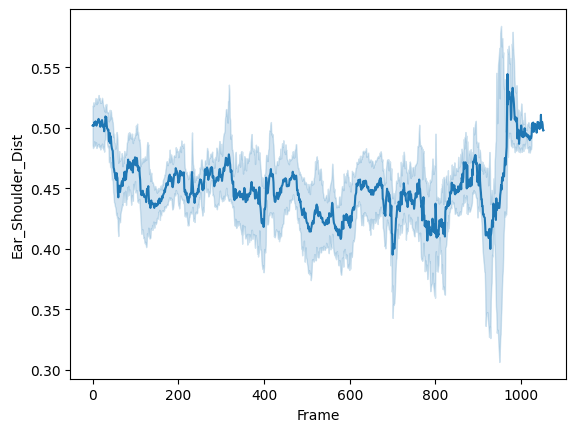

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(data = df[:10000],y='Ear_Shoulder_Dist',x='Frame')

In [ ]:
import pandas as pd
import numpy as np
import glob
import os

# --- 1. 통합 분석 함수 ---
def calculate_all_mermaid_metrics(df):
    df_out = df.copy()

    # (1) 기본 좌표 추출
    # 어깨/골반 중점
    mid_sh_x = (df['norm_Left_Shoulder_x'] + df['norm_Right_Shoulder_x']) / 2
    mid_sh_y = (df['norm_Left_Shoulder_y'] + df['norm_Right_Shoulder_y']) / 2
    mid_hip_x = (df['norm_Left_Hip_x'] + df['norm_Right_Hip_x']) / 2
    mid_hip_y = (df['norm_Left_Hip_y'] + df['norm_Right_Hip_y']) / 2

    # (2) 척추 굴곡 각도 (Segmentation 기준용) ⭐ 필수
    spine_dx = mid_sh_x - mid_hip_x
    spine_dy = mid_sh_y - mid_hip_y
    df_out['Spine_Flexion_Angle'] = np.degrees(np.arctan2(spine_dx, -spine_dy))

    # (3) 골반 기울기
    df_out['Pelvis_Tilt_Diff'] = df['norm_Left_Hip_y'] - df['norm_Right_Hip_y']

    # (4) 팔 분석 (왼쪽 기준 예시 - 필요시 오른쪽도 추가)
    ear = df[['norm_Left_Ear_x', 'norm_Left_Ear_y']].values
    shoulder = df[['norm_Left_Shoulder_x', 'norm_Left_Shoulder_y']].values
    elbow = df[['norm_Left_Elbow_x', 'norm_Left_Elbow_y']].values

    # 어깨 으쓱
    df_out['Ear_Shoulder_Dist'] = np.sqrt(np.sum((ear - shoulder)**2, axis=1))

    # 팔 쏠림 (외적)
    vec_head = ear - shoulder
    vec_arm = elbow - shoulder
    df_out['Arm_Alignment_Score'] = (vec_head[:, 0] * vec_arm[:, 1]) - (vec_head[:, 1] * vec_arm[:, 0])

    return df_out

# --- 2. 메인 실행부 ---

# [경로 수정] 본인 PC의 norm 폴더 경로를 넣으세요!
input_folder = r"/content/drive/MyDrive/shared_googledrive(Sessac Final Project)/dataset/Mermaid/norm_11x"
output_folder = r"/content/drive/MyDrive/shared_googledrive(Sessac Final Project)/analysis/Mermaid_Full_Analysis"
os.makedirs(output_folder, exist_ok=True)

all_files = glob.glob(os.path.join(input_folder, "*.csv"))

if not all_files:
    print(f"❌ 파일 없음: {input_folder}")
else:
    print(f"✅ 총 {len(all_files)}개 파일의 전체 지표(척추+골반+팔)를 계산합니다...")

    results_list = []

    for i, file_path in enumerate(all_files):
        try:
            # 메타데이터 추출
            filename = os.path.basename(file_path)
            clean_name = filename.replace('norm_', '').replace('.csv', '')
            parts = clean_name.split('_')

            # (파일명 규칙에 따라 인덱스 수정 필요할 수 있음)
            level = parts[5]
            person_id = parts[6]
            for part in parts:
                if part.startswith('actor'): person_id = part
                if part in ['고급', '중급', '초급']: level = part

            # 데이터 읽기
            df = pd.read_csv(file_path)

            # [중요] 보간 (Interpolation) - 끊김 방지
            norm_cols = [c for c in df.columns if c.startswith('norm_')]
            df[norm_cols] = df[norm_cols].interpolate(method='linear', limit=5)

            # 전체 지표 계산
            df_analyzed = calculate_all_mermaid_metrics(df)

            # 메타데이터 추가
            df_analyzed['Source_File'] = filename
            df_analyzed['Person_ID'] = person_id
            df_analyzed['Level'] = level

            results_list.append(df_analyzed)

        except Exception as e:
            print(f"⚠️ 오류 ({filename}): {e}")

    if results_list:
        final_df = pd.concat(results_list, ignore_index=True)

        # [중요] 이 파일이 생성되어야 다음 단계가 가능합니다!
        save_path = os.path.join(output_folder, "EDA_Mermaid_Full_Metrics.csv")
        final_df.to_csv(save_path, index=False)

        print("-" * 50)
        print(f"✅ 통합 데이터셋 생성 완료!")
        print(f"📂 저장 경로: {os.path.abspath(save_path)}")
        print(f"📊 포함된 컬럼: {list(final_df.columns[-5:])}") # 주요 컬럼 확인

✅ 총 257개 파일의 전체 지표(척추+골반+팔)를 계산합니다...
--------------------------------------------------
✅ 통합 데이터셋 생성 완료!
📂 저장 경로: /content/drive/MyDrive/shared_googledrive(Sessac Final Project)/analysis/Mermaid_Full_Analysis/EDA_Mermaid_Full_Metrics.csv
📊 포함된 컬럼: ['Ear_Shoulder_Dist', 'Arm_Alignment_Score', 'Source_File', 'Person_ID', 'Level']


In [ ]:
import pandas as pd
import numpy as np
import glob
import os
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from google.colab import drive

# 1. 드라이브 마운트
try:
    drive.mount('/content/drive')
except:
    pass

# --- 1. 사이클 처리 함수 ---

def segment_and_normalize_cycles(df, metric_col='Spine_Flexion_Angle', num_points=100):
    """
    시계열 데이터에서 반복 동작(Cycle)을 찾아내고,
    모든 동작을 0~100 (num_points) 길이로 정규화하여 반환
    """
    # 1. 신호 다듬기 (노이즈 제거를 위해 이동평균 적용)
    # Mermaid는 척추 각도가 커졌다 작아지는 동작이므로 절댓값 사용
    signal = df[metric_col].abs().rolling(window=5, center=True).mean().fillna(0)

    # 2. 피크(Peak) 찾기 (동작의 정점)
    # height: 최소 15도 이상은 굽혀야 동작으로 인정
    # distance: 피크 간 최소 간격 (30프레임 = 약 1초)
    peaks, _ = find_peaks(signal, height=15, distance=30)

    cycles_list = []

    for i, peak_frame in enumerate(peaks):
        # 3. 각 피크를 중심으로 시작/끝 찾기 (Valley detection)
        # 피크 앞뒤로 각도가 가장 낮은 지점(Valley)을 찾음

        # (간단한 로직: 피크 이전 50프레임, 이후 50프레임 탐색)
        start_search = max(0, peak_frame - 50)
        end_search = min(len(df), peak_frame + 50)

        # 구간 내 최소값의 인덱스 찾기
        segment_before = signal[start_search:peak_frame]
        segment_after = signal[peak_frame:end_search]

        if len(segment_before) == 0 or len(segment_after) == 0: continue

        start_frame = segment_before.idxmin()
        end_frame = segment_after.idxmin()

        # 4. 데이터 잘라내기
        cycle_data = df.loc[start_frame:end_frame].copy()

        if len(cycle_data) < 10: continue # 너무 짧으면 무시

        # 5. [핵심] 시간 정규화 (Time Normalization) -> 0~100%
        # 원래 프레임 (0, 1, 2 ... N) -> 정규화된 인덱스 (0.0 ... 100.0)
        original_steps = np.linspace(0, 100, num=len(cycle_data))
        target_steps = np.linspace(0, 100, num=num_points)

        resampled_cycle = pd.DataFrame()
        resampled_cycle['Progress_Percent'] = target_steps
        resampled_cycle['Cycle_ID'] = i + 1 # 몇 번째 반복인지

        # 모든 숫자형 컬럼에 대해 보간(Interpolation) 적용
        for col in cycle_data.select_dtypes(include=[np.number]).columns:
            f = interp1d(original_steps, cycle_data[col], kind='linear')
            resampled_cycle[col] = f(target_steps)

        # 메타데이터 복사 (첫 행 기준)
        for col in ['Person_ID', 'Level', 'Source_File']:
            if col in cycle_data.columns:
                resampled_cycle[col] = cycle_data[col].iloc[0]

        cycles_list.append(resampled_cycle)

    if cycles_list:
        return pd.concat(cycles_list, ignore_index=True)
    else:
        return None

# --- 2. 메인 실행부 ---

# [파일 경로 - 아까 만든 전체 프레임 파일]
input_file = '/content/drive/MyDrive/shared_googledrive(Sessac Final Project)/analysis/Mermaid_Full_Analysis/EDA_Mermaid_Full_Metrics.csv'

if os.path.exists(input_file):
    print("데이터 로드 중...")
    df_all = pd.read_csv(input_file)

    print("각 영상별로 동작(Cycle)을 분할하고 정규화합니다...")

    normalized_results = []

    # 각 파일(Source_File)별로 처리
    for source_file, group in df_all.groupby('Source_File'):
        try:
            # 정규화 수행 (척추 각도 기준)
            norm_cycle_df = segment_and_normalize_cycles(group, metric_col='Spine_Flexion_Angle')

            if norm_cycle_df is not None:
                normalized_results.append(norm_cycle_df)

        except Exception as e:
            print(f"Error processing {source_file}: {e}")

    # 결과 저장
    if normalized_results:
        final_normalized_df = pd.concat(normalized_results, ignore_index=True)

        output_path = '/content/drive/MyDrive/shared_googledrive(Sessac Final Project)/analysis/Mermaid_Arm_Check/EDA_Mermaid_Normalized_Cycles.csv'
        final_normalized_df.to_csv(output_path, index=False)

        print("-" * 50)
        print(f"✅ 정규화 완료! 총 {final_normalized_df['Cycle_ID'].count() // 100}개의 동작 사이클을 추출했습니다.")
        print(f"📂 저장 경로: {output_path}")
    else:
        print("추출된 동작 사이클이 없습니다.")
else:
    print("입력 파일을 찾을 수 없습니다.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
데이터 로드 중...
각 영상별로 동작(Cycle)을 분할하고 정규화합니다...
--------------------------------------------------
✅ 정규화 완료! 총 1420개의 동작 사이클을 추출했습니다.
📂 저장 경로: /content/drive/MyDrive/shared_googledrive(Sessac Final Project)/analysis/Mermaid_Arm_Check/EDA_Mermaid_Normalized_Cycles.csv


In [ ]:
df_ = pd.read_csv('/content/drive/MyDrive/shared_googledrive(Sessac Final Project)/analysis/Mermaid_Arm_Check/EDA_Mermaid_Normalized_Cycles.csv')
df_

,Progress_Percent,Cycle_ID,Frame,Nose_x,Nose_y,Nose_conf,Left_Eye_x,Left_Eye_y,Left_Eye_conf,Right_Eye_x,...,norm_Left_Ankle_y,norm_Right_Ankle_x,norm_Right_Ankle_y,Spine_Flexion_Angle,Pelvis_Tilt_Diff,Ear_Shoulder_Dist,Arm_Alignment_Score,Person_ID,Level,Source_File
0,0.000000,1,57.000000,1368.400000,1092.750000,0.99,1388.890000,1076.770000,1.00,1352.470000,...,0.409552,0.139457,0.457679,-0.537531,0.004878,0.462969,0.014536,actorP072,고급,norm_필라테스_가산_A_Mat_Mermaid_고급_actor...
1,1.010101,1,57.545455,1369.430909,1094.490000,0.99,1390.079091,1078.395455,1.00,1353.691818,...,0.404790,0.147327,0.450700,0.007170,0.007388,0.461453,0.012228,actorP072,고급,norm_필라테스_가산_A_Mat_Mermaid_고급_actor...
2,2.020202,1,58.090909,1370.644545,1096.304545,0.99,1391.411818,1080.104545,1.00,1355.117273,...,0.400696,0.155824,0.443792,0.539986,0.009440,0.459594,0.009995,actorP072,고급,norm_필라테스_가산_A_Mat_Mermaid_고급_actor...
3,3.030303,1,58.636364,1372.771818,1098.491818,0.99,1393.462727,1082.231818,1.00,1357.560909,...,0.399941,0.167450,0.437244,1.013377,0.009207,0.456021,0.008136,actorP072,고급,norm_필라테스_가산_A_Mat_Mermaid_고급_actor...
4,4.040404,1,59.181818,1375.099091,1100.688182,0.99,1395.748182,1084.339091,1.00,1360.051818,...,0.399905,0.170663,0.435143,1.567424,0.010425,0.454340,0.007401,actorP072,고급,norm_필라테스_가산_A_Mat_Mermaid_고급_actor...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141995,95.959596,2,453.282828,1175.253939,1021.253636,1.00,1191.123939,1008.040707,0.99,1157.903131,...,0.313993,0.121621,0.470901,-5.375586,-0.041639,0.309336,0.172853,actorP050,중급,norm_필라테스_가산_D_Mat_Mermaid_중급_acto...
141996,96.969697,2,454.212121,1181.913030,1020.260909,1.00,1197.944242,1007.630909,0.99,1165.098182,...,0.314700,0.101217,0.471472,-4.292340,-0.034336,0.315872,0.181620,actorP050,중급,norm_필라테스_가산_D_Mat_Mermaid_중급_acto...
141997,97.979798,2,455.141414,1186.086970,1019.880505,1.00,1202.732525,1008.040404,0.99,1170.470303,...,0.290723,0.034681,0.447135,-1.979841,-0.022007,0.340183,0.179513,actorP050,중급,norm_필라테스_가산_D_Mat_Mermaid_중급_acto...
141998,98.989899,2,456.070707,1191.640000,1019.727071,1.00,1208.371515,1007.908889,0.99,1175.773939,...,0.296825,0.025890,0.454275,-0.710814,-0.013233,0.354113,0.190611,actorP050,중급,norm_필라테스_가산_D_Mat_Mermaid_중급_acto...


In [ ]:
# 파일 로드
df = pd.read_csv('/content/drive/MyDrive/shared_googledrive(Sessac Final Project)/analysis/Mermaid_Arm_Check/EDA_Mermaid_Normalized_Cycles.csv') # 경로 수정 필요

# 'Ear_Shoulder_Dist'의 통계량 확인
print(df['Ear_Shoulder_Dist'].describe())

# 하위 1%, 5% 값 확인 (이상치 제외한 최소값 찾기)
bottom_1 = df['Ear_Shoulder_Dist'].quantile(0.01)
bottom_5 = df['Ear_Shoulder_Dist'].quantile(0.05)

print(f"\n--- 📉 기준값 후보 ---")
print(f"최소값 (Min): {df['Ear_Shoulder_Dist'].min():.3f}")
print(f"하위 1% 선: {bottom_1:.3f}")
print(f"하위 5% 선: {bottom_5:.3f}")

count    127600.000000
mean          0.438673
std           0.060850
min           0.135711
25%           0.397261
50%           0.440981
75%           0.478987
max           0.703055
Name: Ear_Shoulder_Dist, dtype: float64

--- 📉 기준값 후보 ---
최소값 (Min): 0.136
하위 1% 선: 0.294
하위 5% 선: 0.340


In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import os

# --- 1. 설정 ---
# [입력] 전체 프레임 데이터 경로 (아까 만든 통합 파일)
input_file = r"/content/drive/MyDrive/shared_googledrive(Sessac Final Project)/analysis/Mermaid_Full_Analysis/EDA_Mermaid_Full_Metrics.csv"
# [출력] 피크만 모은 파일 경로
output_file = r"/content/drive/MyDrive/shared_googledrive(Sessac Final Project)/analysis/Mermaid_Full_Analysis/EDA_Mermaid_Peaks_Only.csv"

# --- 2. 피크 추출 함수 ---
def extract_peaks_from_video(group):
    """
    한 영상(group) 내에서 척추 각도가 최대인 지점(Peak)들을 모두 찾습니다.
    """
    # 1. 신호 전처리 (절댓값 & 스무딩)
    # abs(): 왼쪽(-) 굽힘도 양수로 변환
    # fillna(0): NaN 방지
    signal = group['Spine_Flexion_Angle'].abs().rolling(window=5, center=True).mean().fillna(0)

    # 2. 피크 찾기 (Scipy 라이브러리)
    # height=15: 최소 15도는 굽혀야 인정
    # distance=40: 한 동작이 끝나고 다음 동작까지 최소 40프레임(1.3초) 간격 필요
    peaks, _ = find_peaks(signal, height=15, distance=40)

    if len(peaks) == 0:
        return None

    # 3. 피크 시점의 데이터 행(Row)만 추출
    peak_rows = group.iloc[peaks].copy()

    # (옵션) 몇 번째 반복인지 표시
    peak_rows['Repetition_Count'] = range(1, len(peak_rows) + 1)

    return peak_rows

# --- 3. 메인 실행 ---
if os.path.exists(input_file):
    print("📂 전체 데이터 로딩 중...")
    df_all = pd.read_csv(input_file)

    print("🏔️ 각 영상별 피크(Peak) 지점을 추출합니다...")

    # 영상별(Source_File)로 그룹화하여 피크 추출 함수 적용
    df_peaks = df_all.groupby('Source_File').apply(extract_peaks_from_video).reset_index(drop=True)

    # 저장
    df_peaks.to_csv(output_file, index=False)

    print("-" * 50)
    print(f"✅ 추출 완료! 저장됨: {output_file}")
    print(f"📊 원본 데이터: {len(df_all)} 행 -> 피크 데이터: {len(df_peaks)} 행")
    print("이제 태블로가 훨씬 가벼워질 겁니다!")
    print("-" * 50)

    # 결과 미리보기
    print(df_peaks[['Source_File', 'Repetition_Count', 'Spine_Flexion_Angle', 'Ear_Shoulder_Dist']].head())

else:
    print(f"❌ 입력 파일을 찾을 수 없습니다: {input_file}")

📂 전체 데이터 로딩 중...
🏔️ 각 영상별 피크(Peak) 지점을 추출합니다...


/tmp/ipython-input-3615126726.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_peaks = df_all.groupby('Source_File').apply(extract_peaks_from_video).reset_index(drop=True)


--------------------------------------------------
✅ 추출 완료! 저장됨: /content/drive/MyDrive/shared_googledrive(Sessac Final Project)/analysis/Mermaid_Full_Analysis/EDA_Mermaid_Peaks_Only.csv
📊 원본 데이터: 212359 행 -> 피크 데이터: 1255 행
이제 태블로가 훨씬 가벼워질 겁니다!
--------------------------------------------------
                                         Source_File  Repetition_Count  \
0  norm_필라테스_가산_A_Mat_Mermaid_고급_actor...                 1   
1  norm_필라테스_가산_A_Mat_Mermaid_고급_actor...                 2   
2  norm_필라테스_가산_A_Mat_Mermaid_고급_actor...                 3   
3  norm_필라테스_가산_A_Mat_Mermaid_고급_actor...                 4   
4  norm_필라테스_가산_A_Mat_Mermaid_고급_actor...                 1   

   Spine_Flexion_Angle  Ear_Shoulder_Dist  
0            17.199396           0.506099  
1            50.649932           0.462840  
2           -22.767311                NaN  
3           -49.015362           0.419275  
4            26.835745           0.4891